In [1]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from tueplots import bundles
import matplotlib.pyplot as plt
import re
import os

In [ ]:
plt.rcParams.update(bundles.neurips2021())

In [2]:
dat_src = r'../dat/bundesnetzagentur/pre_processed_data/prod_price_de_lu_2019_2021.csv'
fig_src = r'../doc/fig/'

In [3]:
combined = pd.read_csv(dat_src,
                       parse_dates=['time'])
combined = combined.set_index('time')
combined = combined.dropna()

In [ ]:
def to_tex(text):
    """
    Helper function to prepare string for latex.
    """
    conv = {
        '&': r'\&',
        '%': r'\%',
        '$': r'\$',
        
        '#': r'\#',
        '_': r'\_',
        '{': r'\{',
        '}': r'\}',
        '~': r'\textasciitilde{}',
        '^': r'\^{}',
        '\\': r'\textbackslash{}',
        '<': r'\textless{}',
        '>': r'\textgreater{}',
    }
    regex = re.compile('|'.join(re.escape(str(key)) for key in sorted(conv.keys(), key = lambda item: - len(item))))
    return regex.sub(lambda match: conv[match.group()], text)

In [ ]:
combined.columns

In [ ]:
# define consistent colors for technologies
tech_colors = {
    'Biomass': '009632ff',
    'Nuclear': 'ff0000ff',
    'Brown Coal': '967d64ff',
    'Black Coal': '323232ff',
    'Natural Gas': 'fa964bff',
    'Pumped-Storage Hydro': '0096e1ff',
    'Wind': 'afc4a5ff',
    'Offshore Wind': '',
    'Onshore Wind': '',
    'Solar': 'ffcd64ff',
    'Hydropower': '0000c8ff',
    # 'Renewable': 'tab:olive',
    # 'Conventional': 'tab:brown'
}

# Regression

In [ ]:
cols = [('Solar', 'tab:orange'), ('Wind', 'tab:blue'), ('Solar & Wind', 'tab:green')]

fig, axs = plt.subplots(1, 3, figsize=(12,3), sharey=True) # figsize=(16,4), 

axs[0].set_ylabel('Price [€/MWh]')

# tmp = combined.sample(15000)

for i in range(0, len(axs)):
    col, color = cols[i]
    ax  = axs[i]
    
    X = combined[col].to_numpy().reshape(-1,1)
    y = combined['Price'].to_numpy()

    reg = LinearRegression()
    reg.fit(X, y)

    m = reg.coef_
    b = reg.intercept_
    
    ax.plot(X, y, 'o', color=color, ms=1, alpha=0.5)
    ax.plot(X, m*X + b, 'black')

    ax.set_xlabel(f'{to_tex(col)} Generation [MWh]')

plt.savefig(os.path.join(fig_src, 'solar_wind_regression.pdf'))

## Comparison of Renewable and Conventional

In [ ]:
renewable = ['Biomass', 
             'Hydropower', 
             'Offshore Wind', 
             'Onshore Wind', 
             'Solar', 
             'Other Renewables']
conventional = ['Nuclear', 
                'Brown Coal', 
                'Black Coal',
                'Natural Gas',
                'Other Conventional Sources']

con_ren                 = combined.copy() # .resample('D').mean()
con_ren['Conventional'] = con_ren.loc[:, conventional].sum(axis=1)
con_ren['Renewable']    = con_ren.loc[:, renewable].sum(axis=1)
con_ren                 = con_ren.filter(['Conventional', 'Renewable', 'Price'])
con_ren['Total']        = con_ren.loc[:, ('Conventional', 'Renewable')].sum(axis=1)

In [ ]:
X_con = con_ren['Conventional'].to_numpy().reshape(-1,1)
X_ren = con_ren['Renewable'].to_numpy().reshape(-1,1)
y     = con_ren['Price']

reg_con = LinearRegression()
reg_ren = LinearRegression()

reg_con.fit(X_con, y)
reg_ren.fit(X_ren, y)

m_con, b_con = reg_con.coef_, reg_con.intercept_
m_ren, b_ren = reg_ren.coef_, reg_ren.intercept_

plt.figure(figsize=(5,3))

ren_color = 'tab:olive'
con_color = 'tab:purple'

plt.plot(X_ren, y, 'o', label='Renewable', color=ren_color, ms=3, alpha=0.4)
plt.plot(X_con, y, 'o', label='Conventional', color=con_color, ms=3, alpha=0.4)

plt.plot(X_ren, m_ren * X_ren + b_ren, 'black', label='Regression Line (Renewable)', linewidth=2)
plt.plot(X_con, m_con * X_con + b_con, 'black', label='Regression Line (Conventional)', linewidth=2, linestyle='dotted')

plt.xlabel('Electricity Generation [MWh]')
plt.ylabel('Price [€/MWh]')

plt.legend(loc='upper right', ncol=2)
plt.savefig(os.path.join(fig_src, 'ren_vs_con_regression.pdf'))
plt.show()

# Pumped-Storage Hydro

In [ ]:
X = combined['Pumped-Storage Hydro'].to_numpy().reshape(-1,1)
y = combined['Price'].to_numpy()

reg = LinearRegression()
reg.fit(X, y)

m = reg.coef_
b = reg.intercept_

plt.figure(figsize=(5,3))

plt.plot(X, y, 'o', color='tab:cyan', ms=3, alpha=0.4)
plt.plot(X, m*X + b, 'black', linewidth=2)

plt.xlabel('Pumped-Storage Hydro Generation [MWh]')
plt.ylabel('Price [€/MWh]')

plt.savefig(os.path.join(fig_src, 'pumped_hydro_regression.pdf'))

# Quarterly Technology Mix with price

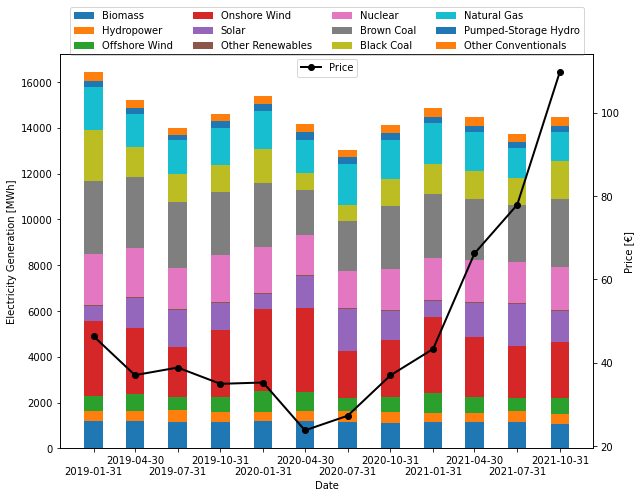

In [166]:
quarterly       = combined.resample('3M').mean()
quarterly.index = pd.to_datetime(quarterly.index.date)
quarterly       = quarterly.loc[:'2021']
quarterly       = quarterly.rename(columns={'Other Conventional Sources': 'Other Conventionals'})

price = quarterly['Price']
quarterly = quarterly.drop(columns=['Price', 'Solar & Wind', 'Wind'])

width = 40
columns = list(quarterly)

fig, ax = plt.subplots(figsize=(9, 7))
ax2 = ax.twinx()

for i, col in enumerate(columns):
    ax.bar(quarterly.index, quarterly[col], width=width, bottom=quarterly[columns[0:i]].sum(axis=1))

ax2.plot(price,
         color='k',
         linewidth=2, 
         marker='o')

ax.set_xlabel('Date')

ax.set_ylabel('Electricity Generation [MWh]')
ax2.set_ylabel('Price [€]')


ax.legend(list(quarterly), ncol=4, loc='upper center',bbox_to_anchor=(0., 1.03, 1., .102))
ax2.legend(['Price'], loc='upper center')


plt.xticks(X)

for tick in ax.xaxis.get_major_ticks()[::2]:
    tick.set_pad(15)

plt.tight_layout()
plt.savefig(os.path.join(fig_src, 'quarterly_technology_mix_with_price.pdf'))
plt.show()